In [2]:
import os
import glob
import torch
import shutil
import rasterio
import numpy as np
import torch
import optuna
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt
from rasterio.crs import CRS
from rasterio.transform import from_bounds, from_origin
from rasterio.io import MemoryFile
from rasterio.merge import merge
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import segmentation_models_pytorch as smp
import multiprocessing as mp
from lightning.pytorch import Trainer,LightningModule
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger

from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from torchgeo.samplers import RandomGeoSampler, GridGeoSampler, RandomBatchGeoSampler, Units
from torchgeo.trainers import SemanticSegmentationTask

from tensorflow.keras.metrics import MeanIoU, Precision, Recall
from sklearn.metrics import classification_report, confusion_matrix

from typing import Iterable, List, Optional, Callable, DefaultDict

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"
os.environ['TENSORBOARD_BINARY'] = '/opt/conda/envs/torch-geo/bin/tensorboard'
torch.cuda.is_available()

2024-12-05 10:41:36.326260: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733395296.563237    4422 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733395296.631381    4422 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 10:41:37.260372: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


True

In [73]:
# glob.glob('../data/valid_imgs/*'), glob.glob('../data/valid_msk/*')

In [4]:
def collate_fn(batch:DefaultDict):
    new_batch = defaultdict(List)
    images = []
    masks = []
    for sample in batch:
        images.append(sample['image'])
        masks.append(sample['mask'])
        
    new_batch['image']= torch.stack(images)
    new_batch['mask']= torch.stack(masks)
    return new_batch


def plot_imgs(images: Iterable, axs: Iterable, bright: float = 3.):
    for img, ax in zip(images, axs):
        arr = img.numpy()[6,:,:]
        ax.imshow(arr)
        ax.axis('off')


def plot_msks(masks: Iterable, axs: Iterable):
    for mask, ax in zip(masks, axs):
        ax.imshow(mask.numpy()[0], cmap='Blues')
        ax.axis('off')

def plot_batch(batch: dict, bright: float = 3., cols: int = 4, width: int = 5):

    # Get the samples and the number of items in the batch
    samples = unbind_samples(batch.copy())
    
    # if batch contains images and masks, the number of images will be doubled
    n = 2 * len(samples) if ('image' in batch) and ('mask' in batch) else len(samples)

    # calculate the number of rows in the grid
    rows = n//cols + (1 if n%cols != 0 else 0)

    # create a grid
    _, axs = plt.subplots(rows, cols, figsize=(cols*width, rows*width))  

    if ('image' in batch) and ('mask' in batch):
        # plot the images on the even axis
        plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1)[::2], bright=bright) 

        # plot the masks on the odd axis
        plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)[1::2]) 

    else:

        if 'image' in batch:
            plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1), bright=bright) 
    
        elif 'mask' in batch:
            plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1))
            
# As simple funtion for computing Intersection over Union (IoU) Precision and Racall
def get_metrics(mask_img, pred_img, num_classes):
    iou_met = MeanIoU(num_classes=num_classes)
    _ = iou_met.update_state(mask_img, pred_img)
    iou1 = float(iou_met.result().numpy())

    pres_met = Precision()
    _ = pres_met.update_state(mask_img, pred_img)
    pres = float(pres_met.result().numpy())

    rec_met = Recall()
    _ = rec_met.update_state(mask_img, pred_img)
    rec = float(rec_met.result().numpy())
    mets = {'Mean-IoU':iou1, 'Precision':pres, 'Recall':rec}
    return mets

#Plot Confusing Matrixs
def MyConfMatix(mask_img, pred_img):
    cm = confusion_matrix(mask_img, pred_img, normalize='true')
    cm_df = pd.DataFrame(cm, columns=['No-Tree','Tree'])
    plt.figure(figsize=(10,8))
    sns.heatmap(cm_df.round(5), annot=True, cmap='Blues')
    plt.ylabel('Masked Treed')
    plt.xlabel('Predicted Trees')

In [5]:
def create_in_memory_geochip(predicted_chip, geotransform, crs, color_coded=False):
    """
    Apply georeferencing to the predicted chip.
    
    Parameters:
        predicted_chip (numpy array): The predicted segmentation chip (e.g., binary mask).
        geotransform (tuple): A tuple containing the geotransformation information of the chip (x-coordinate of the top left corner, x and y pixel size, rotation, y-coordinate of the top left corner, and rotation).
        crs (str): Spatial Reference System (e.g., EPSG code) of the chip.
        color_coded (bool): If the chip is color coded, it has a shape [H, W, C], othersize has a shape [1, H, W]

    Return:
        A rasterio dataset that is georreferenced.
    """
    if color_coded:
        predicted_chip = np.rollaxis(predicted_chip, axis=2) # putting the bands first
        photometric = 'RGB'
    else:
        photometric = 'MINISBLACK'
        
    memfile = MemoryFile()
    dataset = memfile.open(
        driver='GTiff',
        height=predicted_chip.shape[1],
        width=predicted_chip.shape[2],
        count=predicted_chip.shape[0],  # Number of bands
        dtype=np.uint8,
        crs=crs,
        transform=geotransform,
        photometric=photometric,
    )
    
    dataset.write(predicted_chip)
    return dataset

def georreferenced_chip_generator(dataloader, model, crs, pixel_size, colors=None, color_coded=False):
    """
    Apply georeferencing to the predicted chip.
    
    Parameters:
        dataloader (torch.utils.data.Dataloader): Dataloader with the data to be predicted.
        model (an https://github.com/qubvel/segmentation_models.pytorch model): model used for inference.
        crs (str): Spatial Reference System (e.g., EPSG code) of the chip.
        pixel_size (float): Pixel dimensoion in map units.

    Returns:
        A list of georeferenced numpy arrays of the predicted outputs.
    """
    georref_chips_list = []
    for i, sample in enumerate(dataloader):
        image, gt_mask, bbox = sample['image'], sample['mask'], sample['bounds'][0]

        prediction = model.predict(image).sigmoid()
        prediction = (prediction > 0.5).float()
        # prediction = torch.softmax(prediction, dim=1)
        # prediction = torch.argmax(prediction, dim = 1)

        geotransform = from_origin(bbox.minx, bbox.maxy, pixel_size, pixel_size)
        
        if color_coded:
            # applying the original colors
            prediction = colour_code_segmentation(prediction, colors)
            georref_chips_list.append(create_in_memory_geochip(prediction.squeeze(), geotransform, crs, color_coded))
        else:
            print(prediction.numpy().shape)
            georref_chips_list.append(create_in_memory_geochip(prediction.numpy()[0], geotransform, crs, color_coded))
    return georref_chips_list

def merge_georeferenced_chips(chips_list, output_path):
    """
    Merge a list of georeferenced chips into a single GeoTIFF file.

    Parameters:
        chips_generator (generator): A generator of Rasterio datasets representing the georeferenced chips.
        output_path (str): The path where the merged GeoTIFF file will be saved.

    Returns:
        None
    """
    # Merge the chips using Rasterio's merge function
    merged, merged_transform = merge(chips_list)
    
    # Calculate the number of rows and columns for the merged output
    rows, cols = merged.shape[1], merged.shape[2]

    # Update the metadata of the merged dataset
    merged_metadata = chips_list[0].meta
    merged_metadata.update({
        'height': rows,
        'width': cols,
        'transform': merged_transform
    })

    # Write the merged array to a new GeoTIFF file
    with rasterio.open(output_path, 'w', **merged_metadata) as dst:
        dst.write(merged)
        
    for chip in chips_list:
        chip.close()

## Load Data

In [6]:
class CustomImageDataset(RasterDataset):
    filename_glob = '*.tif'
    is_image = True
    separate_files = False
    all_bands = ('VV_DB','VH_DB','B02','B03','B04','B08','NDVI','EVI2','NDMI','DEM')
    rgb_bands = ('B04','B03','B02')
    
class CustomMaskDataset(RasterDataset):
    filename_glob = '*.tif'
    is_image = False

In [9]:
# initialize the raster and label datasets
train_images = CustomImageDataset(
    paths = [
        '../data/train_imgs/'
    ],
    crs='epsg:32630', 
    res=10
)

valid_images = CustomImageDataset(
    paths = [
        '../data/valid_imgs/'
    ],
    crs='epsg:32630', 
    res=10
)

train_masks = CustomMaskDataset(
    paths=[
        '../data/train_msk/'
    ],
    crs='epsg:32630', 
    res=10
)


valid_masks = CustomMaskDataset(
    paths=[
        '../data/valid_msk/'
    ],
    crs='epsg:32630', 
    res=10
)

In [10]:
training_data = train_images & train_masks
validation_data = valid_images & valid_masks

In [11]:
train_sampler = RandomGeoSampler(training_data, size=512, length=200, units=Units.PIXELS)
valid_sampler = RandomGeoSampler(validation_data, size=512, length=50, units=Units.PIXELS)

In [12]:
workers = mp.cpu_count()

train_dataloader = DataLoader(training_data, sampler=train_sampler, batch_size=16, num_workers=workers, collate_fn=collate_fn)
valid_dataloader = DataLoader(validation_data, sampler=valid_sampler, batch_size=8, num_workers=workers, collate_fn=collate_fn)

In [13]:
train_batch = next(iter(train_dataloader))
valid_batch = next(iter(valid_dataloader))

In [14]:
train_batch['image'].shape

torch.Size([16, 10, 512, 512])

In [15]:
train_batch['mask'].shape

torch.Size([16, 1, 512, 512])

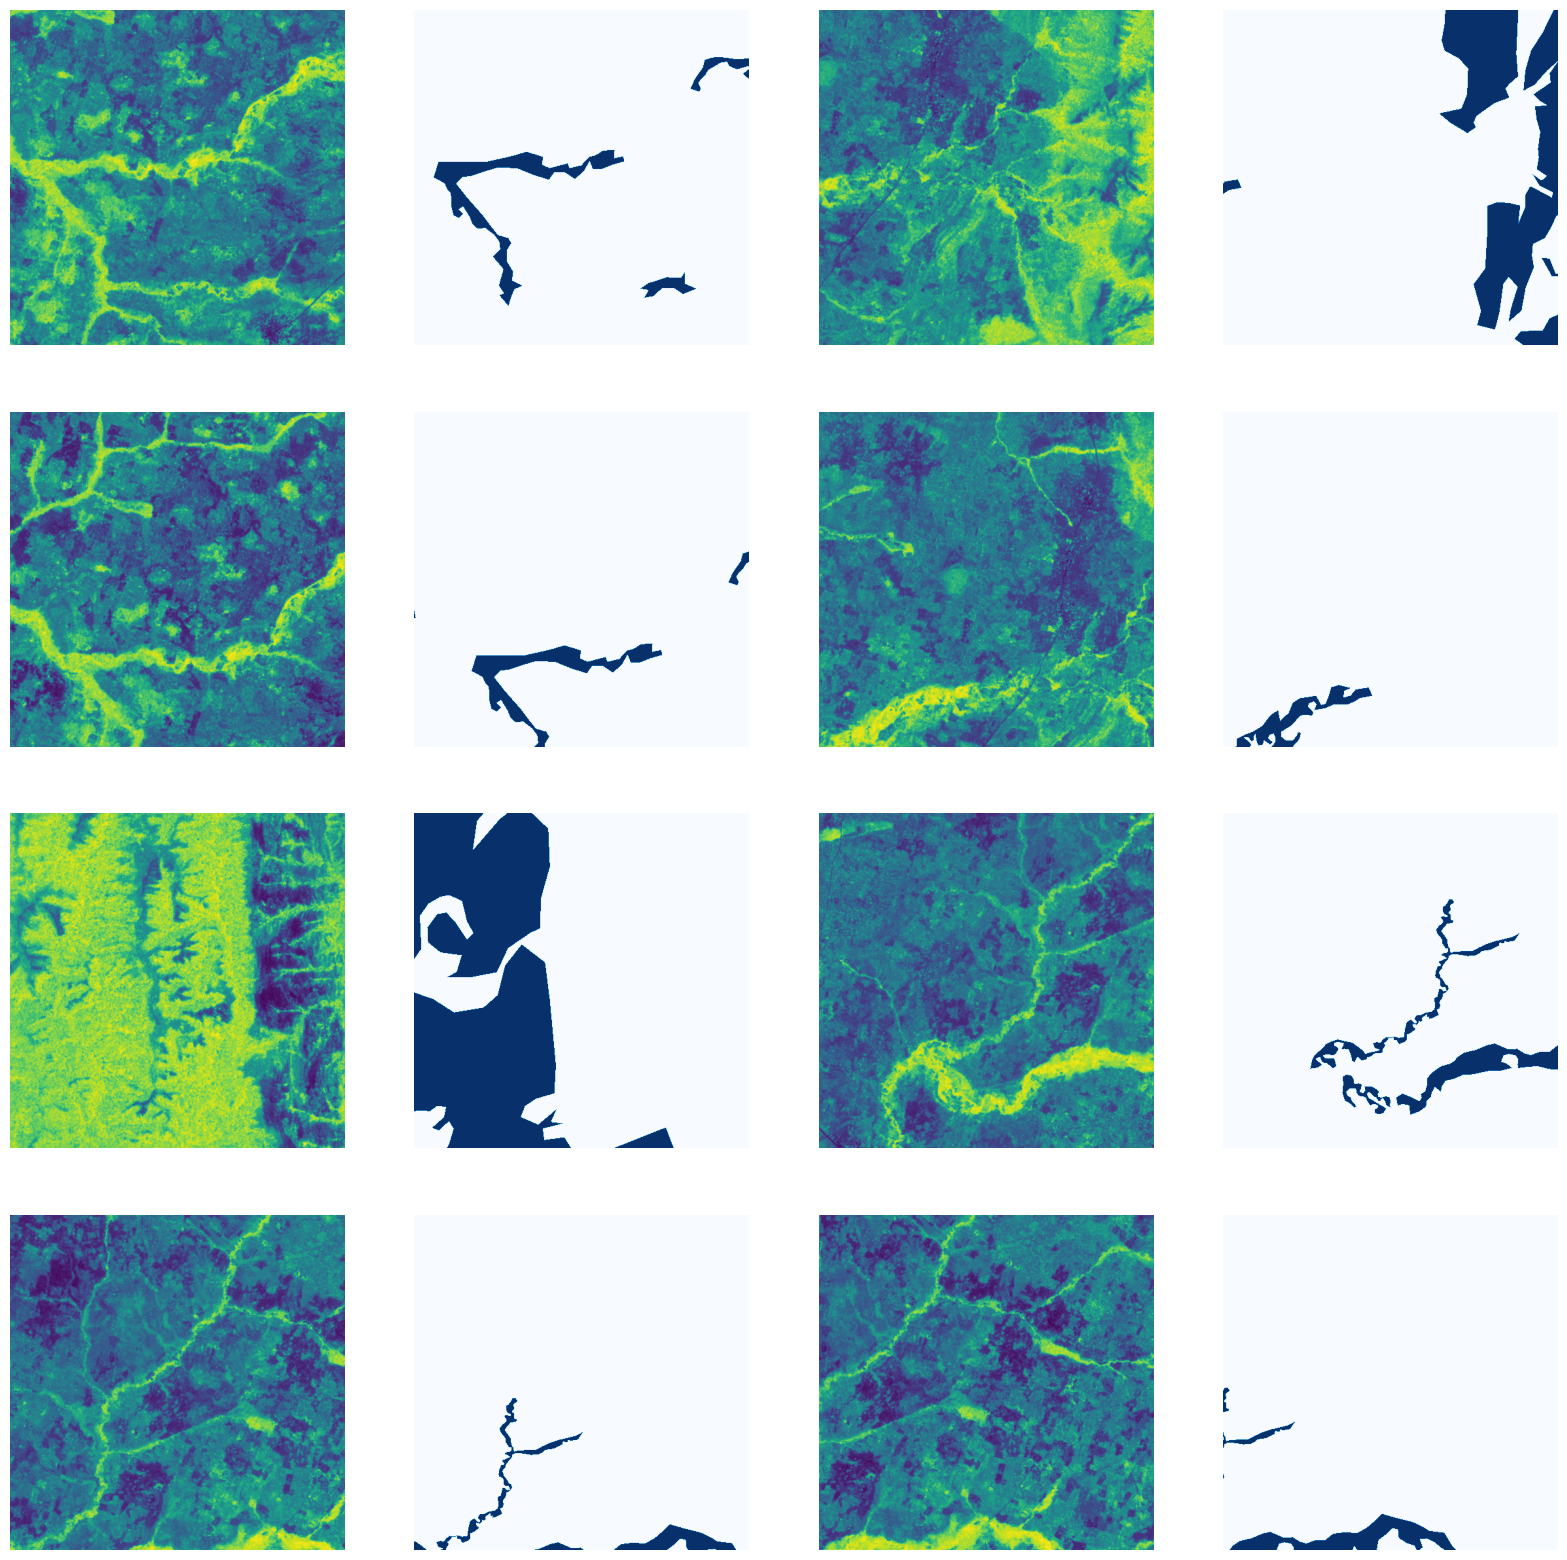

In [16]:
plot_batch(valid_batch)

## Build and Run Model

In [23]:
EPOCHS = 100
T_MAX = EPOCHS * len(train_dataloader)

In [24]:
class SegmentationModel(LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes,lr, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )
        self.lr = lr
        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        # initialize step metics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # normalize image here
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), mask.long(), mode="binary"
        )
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }
        return

In [25]:
segmodel = SegmentationModel(arch='Unet', encoder_name='resnet50', in_channels=10, out_classes=1, lr=1e-4)

In [26]:
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
checkpoint_callback = ModelCheckpoint(dirpath='../model_ckpt/', filename='unet_model_E100', save_top_k=1, save_last=True)
logger = TensorBoardLogger(save_dir='../model_logs/', name='logs')

In [27]:
model_trainer = Trainer(
    accelerator=accelerator,
    callbacks=[checkpoint_callback],
    fast_dev_run=False,
    log_every_n_steps=1,
    logger=logger,
    min_epochs=5,
    max_epochs=EPOCHS
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [28]:
model_trainer.fit(model=segmodel, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

/opt/conda/envs/torch-geo/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/jupyter/model_ckpt exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | Unet     | 32.5 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
32.5 M    Trainable params
0         Non-trainable params
32.5 M    Total params
130.172   Total estimated model params size (MB)
224       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


## Model Tuninig

In [ ]:
def objective(trial):
    encs = trail.suggest_categorical('encs', ['resnet34','resnet50'])
    lr = trial.suggest_float('lr', 1e-5, 1e-2)

    segmodel = SegmentationModel(arch='Unet', encoder_name=encs, in_channels=10, out_classes=1, lr=lr)
    model_trainer = Trainer(
    accelerator=accelerator,
    callbacks=[checkpoint_callback],
    fast_dev_run=False,
    log_every_n_steps=1,
    logger=logger,
    min_epochs=5,
    max_epochs=EPOCHS
)

    trainer.fit(model)
    return trainer.callback_metrics['val_loss']

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

best_params = study.best_params

## Check Model Performance

In [ ]:
# from captum.attr import visualization as viz
# from captum.attr import LayerGradCam, FeatureAblation, LayerActivation, LayerAttribution

In [ ]:
# attributions, delta = ig.attribute(input, baseline, target=0, return_convergence_delta=True)
# print('IG Attributions:', attributions)
# print('Convergence Delta:', delta)

In [29]:
%reload_ext tensorboard
%tensorboard --logdir ../model_logs/logs

Reusing TensorBoard on port 6006 (pid 22976), started 2:07:42 ago. (Use '!kill 22976' to kill it.)

## Test and Model and Make Predictions

I0000 00:00:1733403389.935428    4422 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13736 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


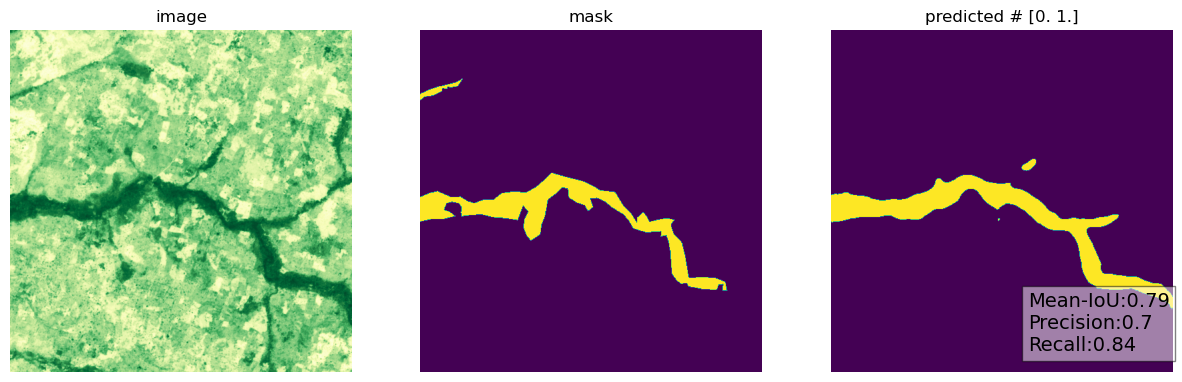

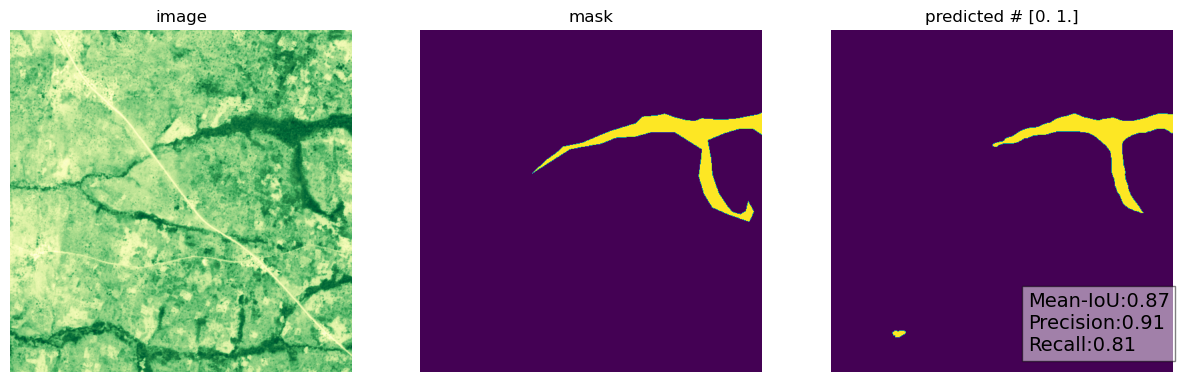

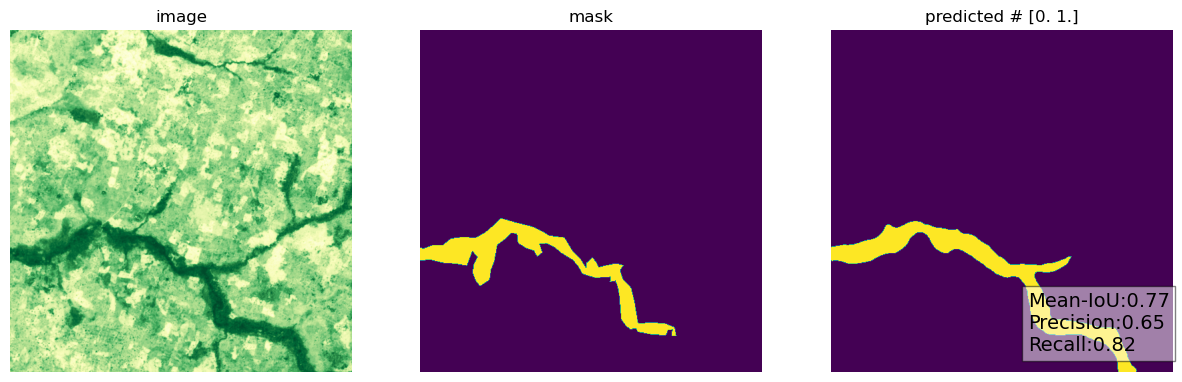

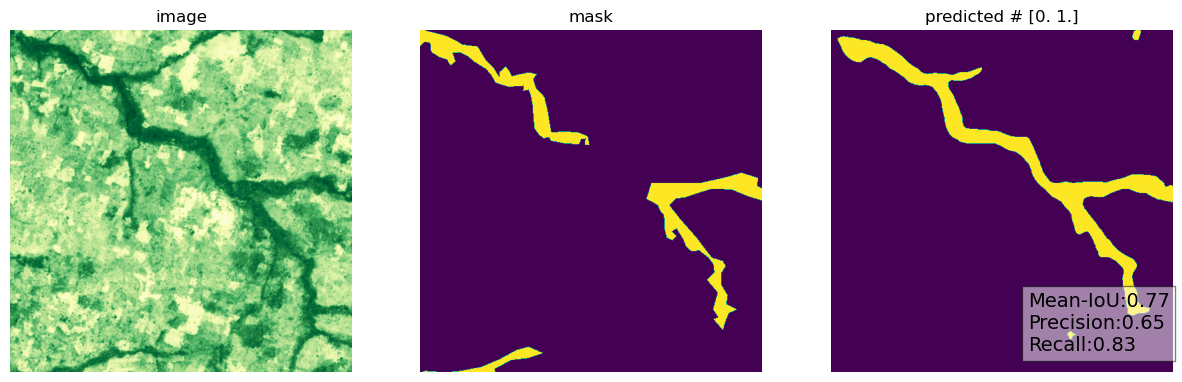

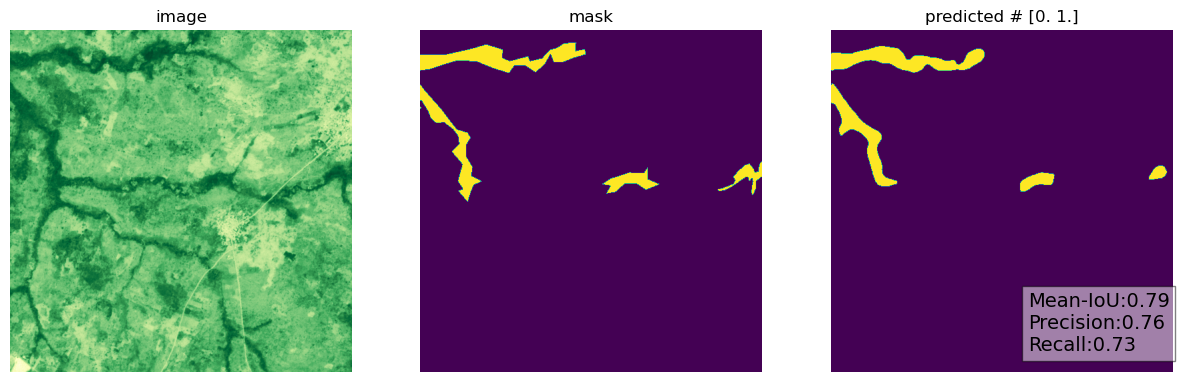

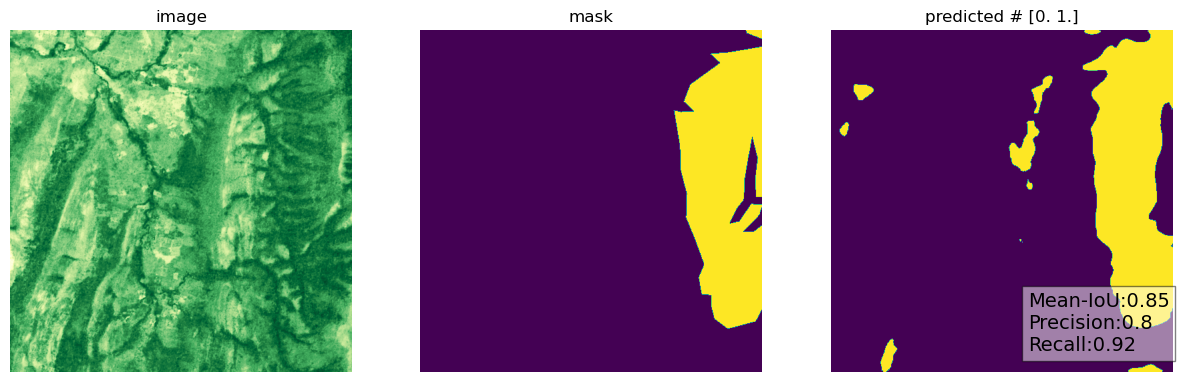

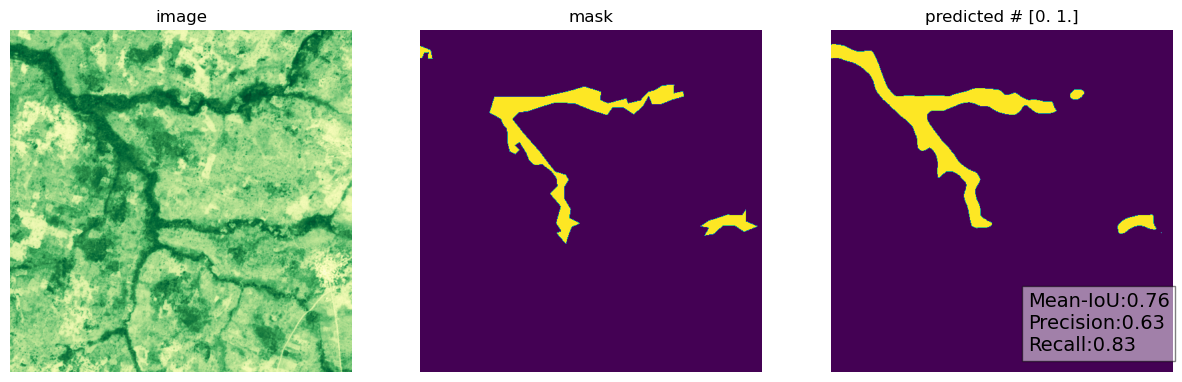

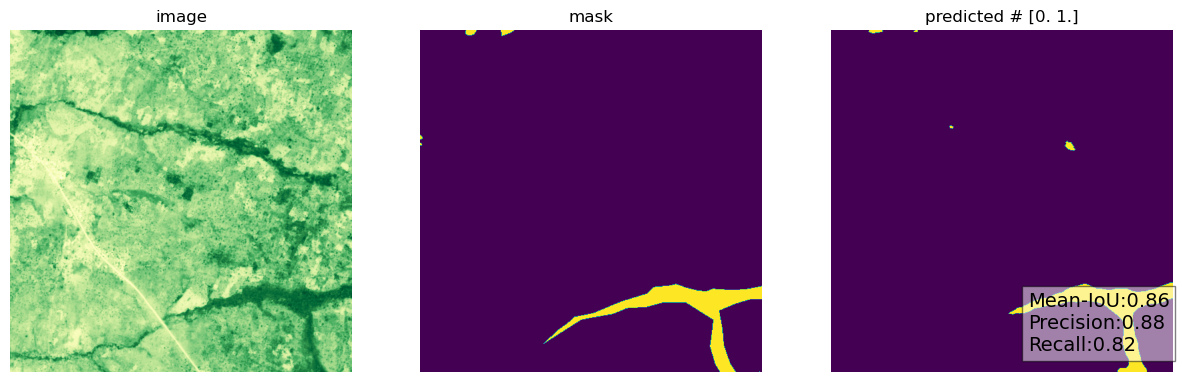

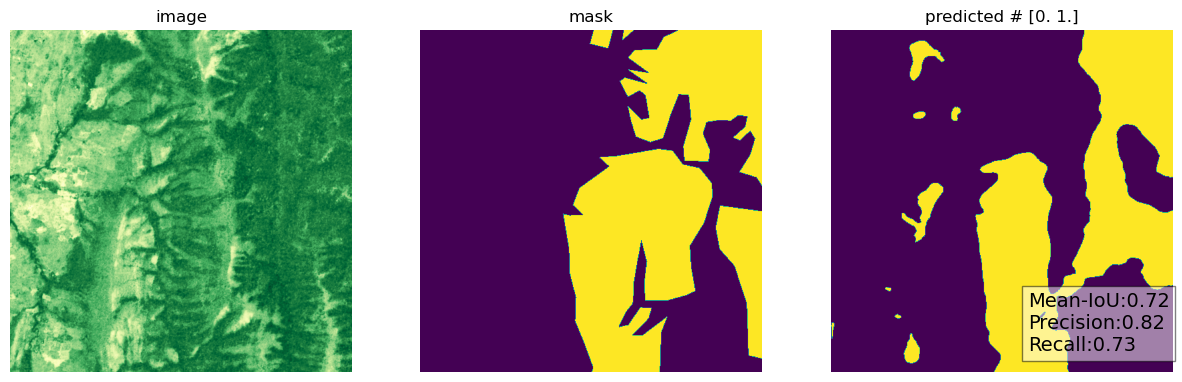

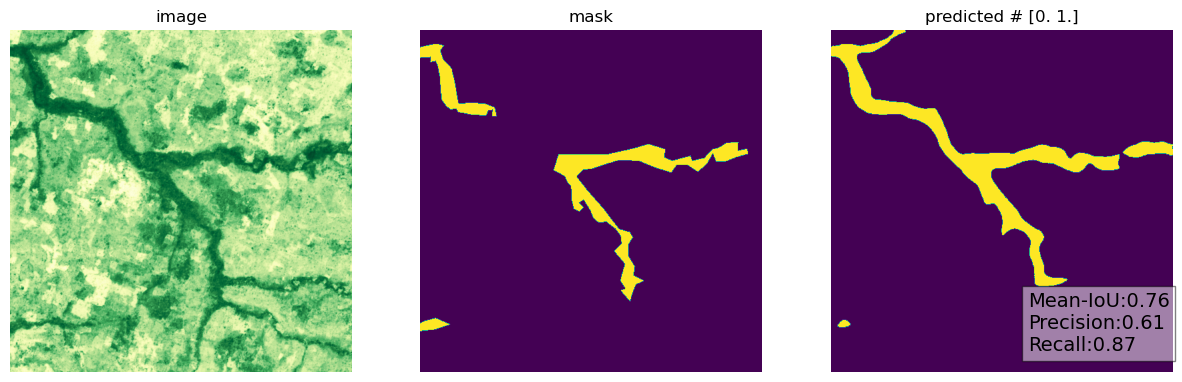

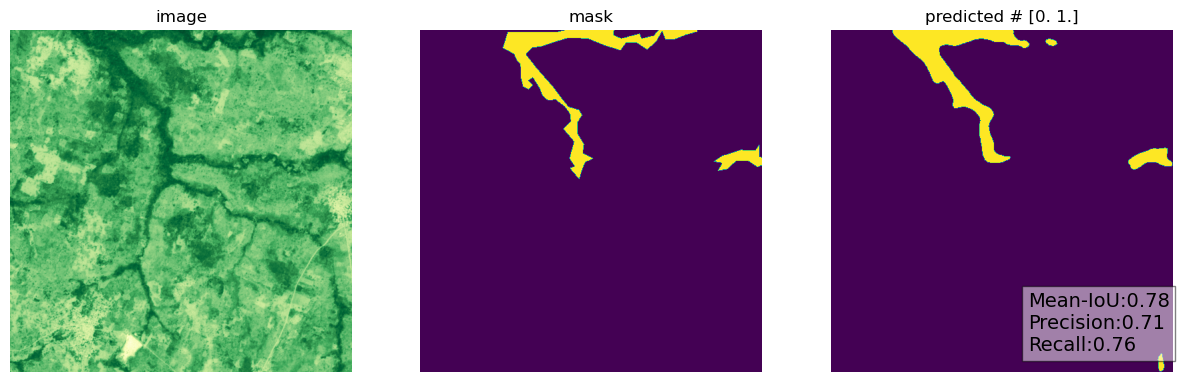

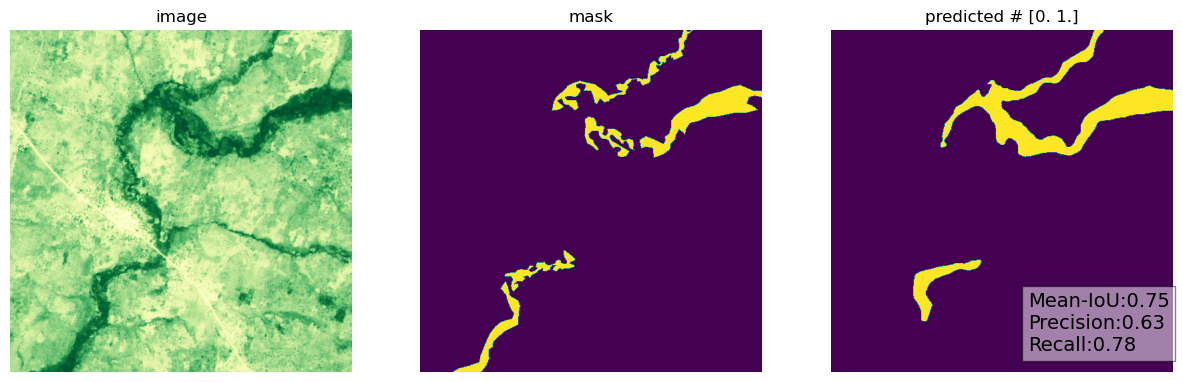

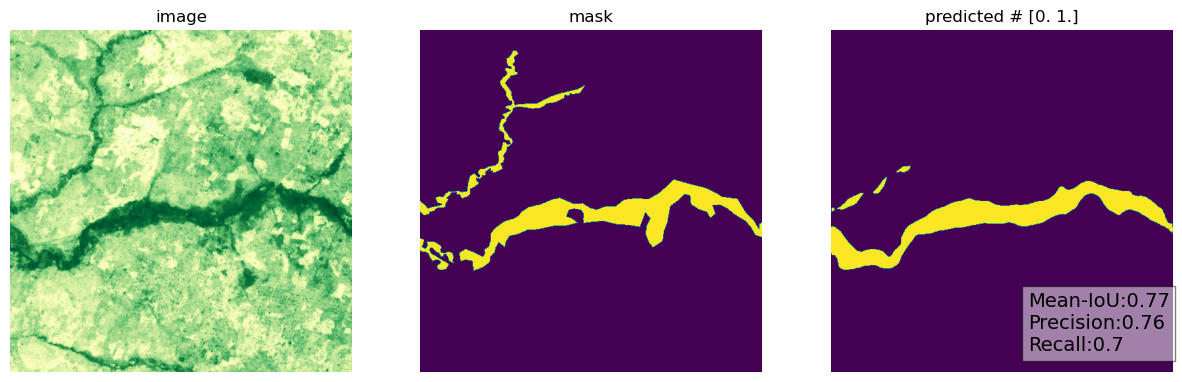

In [30]:
test_sampler = RandomGeoSampler(validation_data, size=512, length=20)
test_dataloader = DataLoader(validation_data, sampler=test_sampler, collate_fn=stack_samples)

for i, sample in enumerate(test_dataloader):
    image, gt_mask, bbox = sample['image'], sample['mask'], sample['bounds'][0]

    prediction = segmodel.model.predict(image).sigmoid()
    prediction = (prediction > 0.5).float()
    # print(image.squeeze().shape, gt_mask.numpy().squeeze().shape, prediction.numpy().squeeze().shape)
    if len(np.unique(gt_mask.numpy()))>1:
        eval_mets = get_metrics(gt_mask.numpy().squeeze(), prediction.numpy().squeeze(), num_classes=2)
        iou, pres, rec = eval_mets['Mean-IoU'], eval_mets['Precision'], eval_mets['Recall'] 
        if rec >= 0.70:
            fig, axs = plt.subplots(nrows=1,ncols=3, figsize=(15, 9))            
            for a, ax in enumerate(axs.reshape(-1)):
                arr = [image.squeeze().numpy()[6], gt_mask.numpy().squeeze(), prediction.numpy().squeeze()][a]
                cat = ['image','mask','predicted'][a]
                ax.set_title(f'{cat}')
                if cat == 'predicted':
                    ax.set_title(f'{cat} # {np.unique(arr)}' )
                    txt = ax.text(x=295, y=480, s=f'Mean-IoU:{np.round(iou, 2)}\nPrecision:{np.round(pres, 2)}\nRecall:{np.round(rec, 2)}', fontsize=14)
                    txt.set_bbox(dict(facecolor='white', alpha=0.5))
                if (cat == 'mask') or (cat=='predicted'):
                    cmap = 'viridis'
                else:
                    cmap='YlGn'
                ax.imshow(arr, cmap=cmap)
                ax.axis('off')

In [31]:
test_sampler = GridGeoSampler(validation_data, size=512, stride=500)
test_dataloader = DataLoader(validation_data, sampler=test_sampler, collate_fn=stack_samples)

pixel_size = valid_images.res
crs = valid_images.crs

chips_generator = georreferenced_chip_generator(test_dataloader, segmodel.model, crs, pixel_size, color_coded=False)

file_name = '../output/merged_prediction_unet_512a.tif'
merge_georeferenced_chips(chips_generator, file_name)


(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 51

In [108]:
crs

'epsg:32630'

In [32]:
out_img = rasterio.open('../output/merged_prediction_unet_512a.tif')

In [33]:
out_img.crs

CRS.from_epsg(32630)

In [34]:
plt.figure(figsize=(10,10))
plt.imshow(out_img.read(1))

In [124]:
def save_tiff(image, output_path):
    merged = image.read()
    # Calculate the number of rows and columns for the merged output
    rows, cols = merged.shape[1], merged.shape[2]

    # Update the metadata of the merged dataset
    merged_metadata = image.meta
    merged_metadata.update({
        'height': rows,
        'width': cols,
        'transform': image.transform
    })

    # Write the merged array to a new GeoTIFF file
    with rasterio.open(output_path, 'w', **merged_metadata) as dst:
        dst.write(merged)

In [125]:
save_tiff(out_img, '../output/merged_prediction_unet_512_new.tif')